In [1]:
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df
from scipy import stats


In [2]:
#load data into df
df_fakecovidNews = pd.read_csv('./Data/covid-19_misinformation_clean.csv')

## Usefull functions

In [3]:
def getSubLinksFromIntro(website, nombreMax=10):
    link = "https://en.wikipedia.org/wiki/"+website

    #load online the html file 
    r = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')

    intro = soup.find_all('div', attrs={'class':'mw-content-ltr mw-parser-output'})[0].find_all('p')
    #get the all the href
    links = []
    for i in intro:
        #get the link and not the <a> tag
        try:
            currentLink = i.find_all('a', href=True)[0]['href']
            if(currentLink[0] == '#'):
                continue
            links.append(currentLink)
        except:
            pass

        if(len(links) >= nombreMax):
            break
    
    return links

In [4]:
def existed(article, dateMin="2020-03-01"):
    #check if the first timestamp is less dateMin 
    if pd.Timestamp(article.iloc[0]['timestamp']) <= pd.Timestamp(dateMin):
        return True
    else:
        return False  


def getSubLinksFromIntroPablo(links):
    views = []
    for link in links:
        result = fetch_pageview_count("en", link)
        if(len(result) != 0):
            views.append(result)

    return views[0]

In [5]:
#make subplot of all the views of dfViewFinal
def plotAllInfos(topic, function):

    fig, axs = plt.subplots(len(topic.dfViewFinal)//3 + 1, 3, figsize=(15, len(topic.dfViewFinal)), sharex=True)
    for i in range(len(topic.dfViewFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewFinal[i]['timestamp'], function(topic.dfViewFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewFinal[i]['article'].unique()[0])

        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


    #make subplot of all the views of dfViewSubLinksFinal
    fig, axs = plt.subplots(len(topic.dfViewSubLinksFinal)//3+1, 3, figsize=(15, len(topic.dfViewSubLinksFinal)), sharex=True)
    for i in range(len(topic.dfViewSubLinksFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewSubLinksFinal[i]['timestamp'], function(topic.dfViewSubLinksFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewSubLinksFinal[i]['article'].unique()[0])
        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


def plotMainInfos(topic, function):
    fig, axs = plt.subplots(len(topic.dfViewFinal)//3 + 1, 3, figsize=(15, len(topic.dfViewFinal)), sharex=True)
    for i in range(len(topic.dfViewFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewFinal[i]['timestamp'], function(topic.dfViewFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewFinal[i]['article'].unique()[0])

        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


def getViewsNormalizedTotal(topic, function):
    dftemp = topic.dfViewFinal.copy()

    columns = ["timestamp", "viewNormalized"]
    newdf = pd.DataFrame(columns=columns)

    for i in range(len(topic.dfViewFinal)):
        dftemp[i]["viewNormalized"] = function(topic.dfViewFinal[i]['views'])
        newdf = pd.concat([newdf, dftemp[i][["timestamp", "viewNormalized"]]], ignore_index=True)

    newdf = newdf.groupby("timestamp").sum()

    return newdf
    

 Functions for normalization of the data (ex relative increase ect ect)

In [6]:
def standarization(array):
    return (array - np.mean(array)) / np.std(array)

def minMax(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def nonefunction(array):
    return array

In [7]:
class wikiTopic:
    df = []

    links = []
    dfView = []
    dfViewFinal = []

    dfSubLinks = []
    dfViewSubLinks = []
    dfViewSubLinksFinal = []

    dfLInksPerArticle = []

    dfSeelectArticles = []
    featureInfo = []

    def __init__(self, df, Maintopic):

        self.dfView = []
        self.dfViewFinal = []
        self.dfViewSubLinks = []
        self.dfViewSubLinksFinal = []
        
        indexes = df["Main Heading"]==Maintopic
        self.df = df[indexes]

        self.extractLinksFromDf()
        self.getViews()

    def extractLinksFromDf(self):

        linksFinal = []
        for links in self.df.clean_articles:
            links = links[1:-1]
            links = links.split(',')

            links = [re.sub(r'[\[\]\'\s]', '', link) for link in links]
            links = [re.sub(r'/wiki/', '', link) for link in links]
            
            #concatenate the list
            linksFinal = linksFinal + links
        
        self.links = list(set(linksFinal))

    def getViews(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo([self.links])
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewFinal.append(viewsdf[keys[i]])
            self.dfView.append(viewsdf[keys[i]])
            
    def getSublinks(self):
        for i in range(len(self.links)):
            allSublinks = getSubLinksFromIntro(self.links[i])
            allSublinks = [re.sub(r'/wiki/', '', link) for link in allSublinks]
            #if the sublinks have "#cite_" remove them 
            allSublinks = [link for link in allSublinks if "#cite_" not in link]
            self.dfSubLinks = self.dfSubLinks + allSublinks

        self.dfSubLinks = list(set(self.dfSubLinks))

    def getViewsSubLinks(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo(self.dfSubLinks)
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewSubLinksFinal.append(viewsdf[keys[i]])
            self.dfViewSubLinks.append(viewsdf[keys[i]])


# Wikiepdia Global Trend

In [8]:
rollingAverage = 15

In [9]:
DATA_FOLDER = 'Data/'

INTERVENTIONS_DATASET = DATA_FOLDER+"interventions.csv"
TOPICS_LINKED_DATASET = DATA_FOLDER+"topics_linked.csv"
GLOBAL_MOBILITY_DATASET = DATA_FOLDER+"Global_Mobility_Report.csv"
APPLE_MOBILITY_DATASET = DATA_FOLDER+"applemobilitytrends-2020-04-20.csv"
TIMESERIES_DATASET = DATA_FOLDER+"aggregated_timeseries.json.gz"

In [10]:
agg = pd.read_json(TIMESERIES_DATASET, compression='gzip')
second_row = agg[['en']].iloc[1]
df = pd.DataFrame(second_row)
dic = df['sum'].iloc[0]



In [132]:
timestamps = np.array(list(dic.keys()))
views = np.array(list(dic.values()))

#get the index of timestamp where 2020-01-01
indexStart = np.where(timestamps == '2020-01-01 00:00:00')[0][0]
indexEnd = np.where(timestamps == '2020-07-01 00:00:00')[0][0]

timestamps = timestamps[indexStart:indexEnd]
views = views[indexStart:indexEnd]


timestamp_wiki = timestamps
views_wiki = views


#rolling avergae 
views = pd.Series(views).rolling(rollingAverage).mean()



In [12]:
def plotNormalization(views, function, args = None, timestamps=timestamps):
    #plot the values of the x axis every week
    plt.figure(figsize=(20,5))
    if args == None:
        plt.plot(timestamps, function(views))
    else:
        plt.plot(timestamps, function(views, *args))
    plt.xticks(timestamps[::rollingAverage], rotation=45)


    plt.title('Views of all the wikipedia articles')

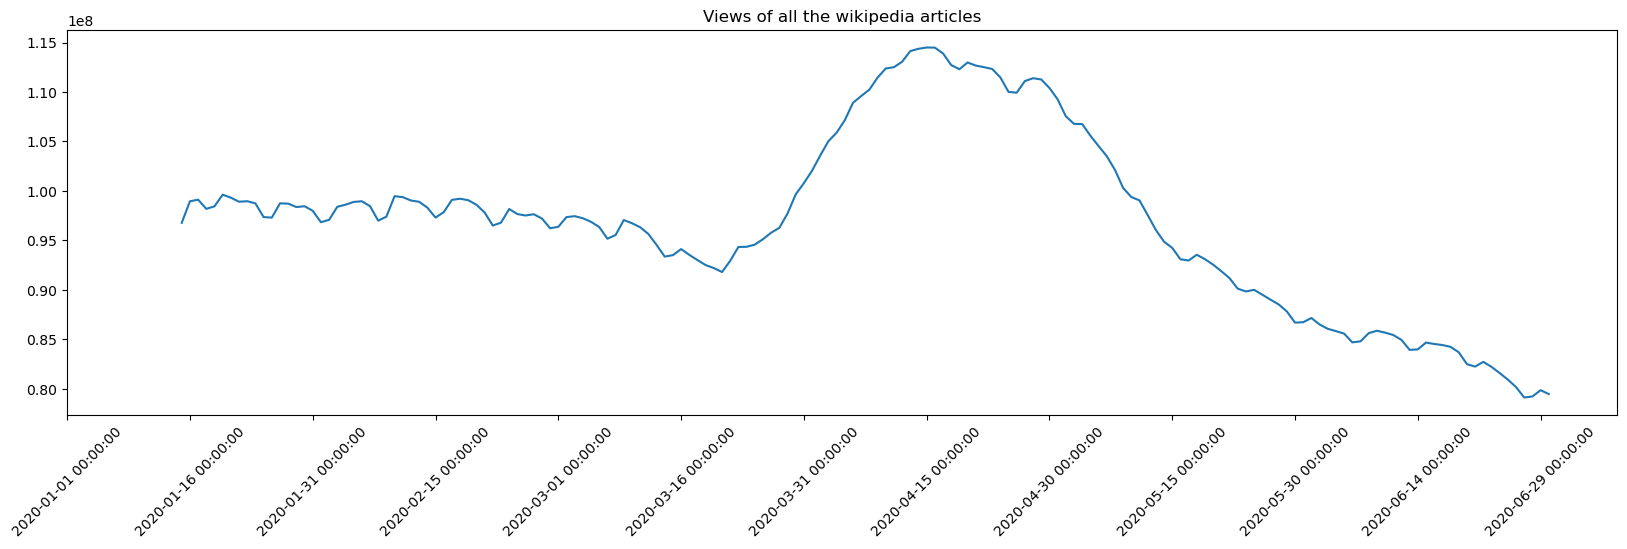

In [13]:
plotNormalization(views, nonefunction)

### First Normalization idea (X-Xb)/Xb

In [14]:
def norm(views):
    print(views.mean())
    return views/views.mean()-1

96908800.80674602


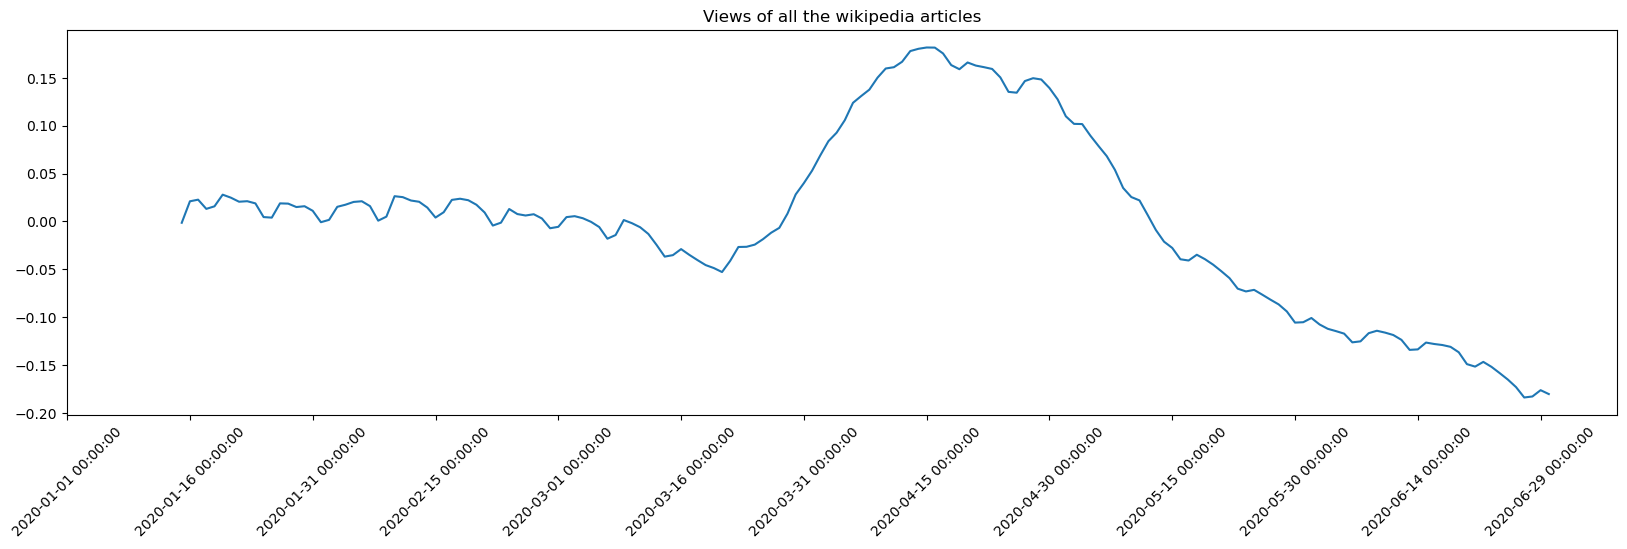

In [15]:
plotNormalization(views, norm)

### Relative increase compared to past month

In [16]:
def relativeToLastMonth(viewsDF, numberOfDays=30):
    views = viewsDF.copy()
    finalView = []
    for i in range(len(views)):
        if(i < numberOfDays):
            pastDays = views[0:i]
            pastDays = pastDays[~np.isnan(pastDays)]

            finalView.append(views[i]/pastDays.mean()-1)
        else:
            pastMonth = views[i-numberOfDays:i]
            pastMonth = pastMonth[~np.isnan(pastMonth)]
            finalView.append(views[i]/pastMonth.mean()-1)
    return finalView

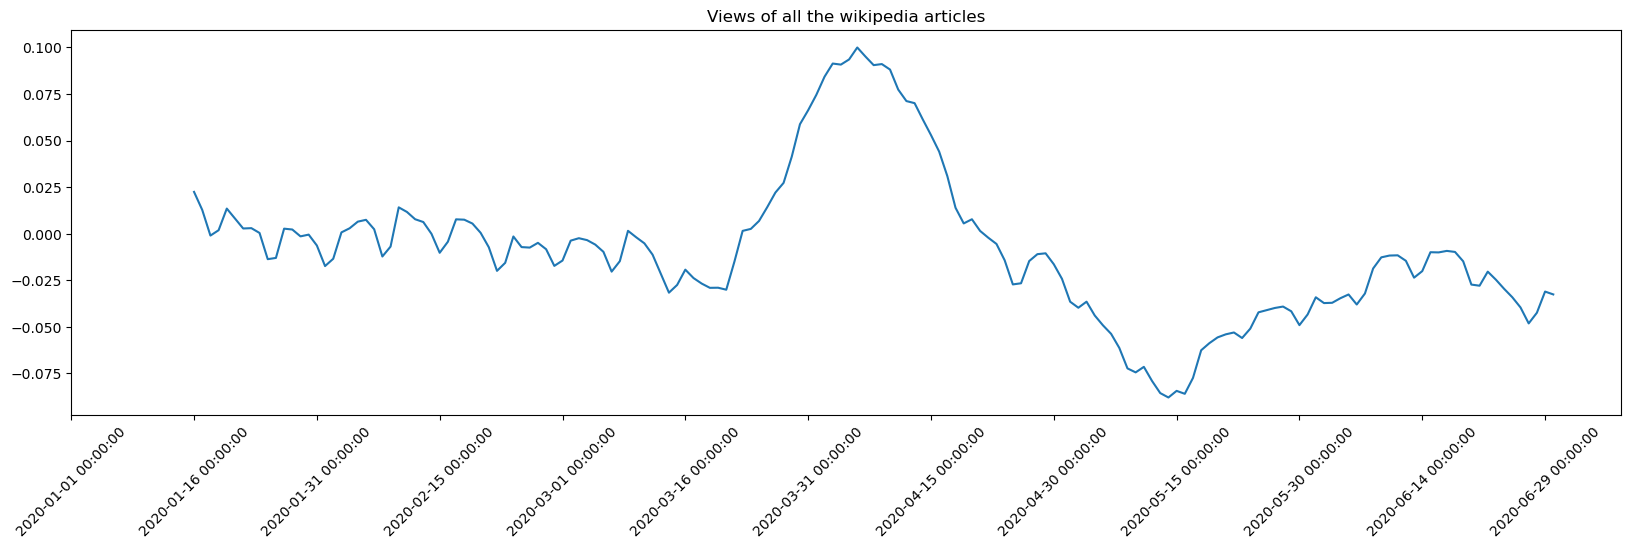

In [17]:
plotNormalization(views, relativeToLastMonth, [15])

## Min-Max

In [18]:
def minMax(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))



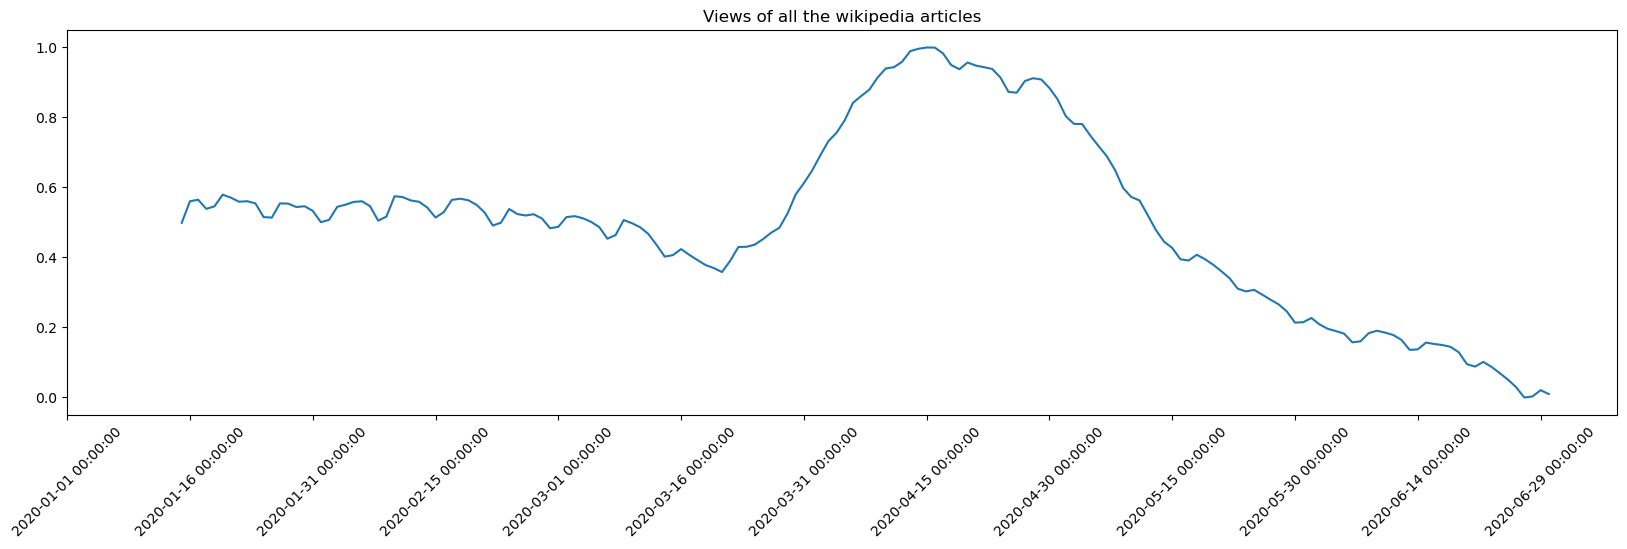

In [19]:
plotNormalization(views, minMax)

### Max Local (null)

In [20]:
def maxLocal(views, lenght):
    finalView = []
    for i in range(len(views)):
        if(i < lenght):
            try:
                pastDays = views[0:i]
                pastDays = pastDays[~np.isnan(pastDays)]
                finalView.append(max(pastDays))
            except:
                finalView.append(0)
        else:
            try:
                pastDays = views[i:i+lenght]
                pastDays = pastDays[~np.isnan(pastDays)]
                finalView.append(max(pastDays))
            except:
                finalView.append(0)

        #where it is 0 put nan
        if(finalView[i] == 0):
            finalView[i] = np.nan
    return finalView

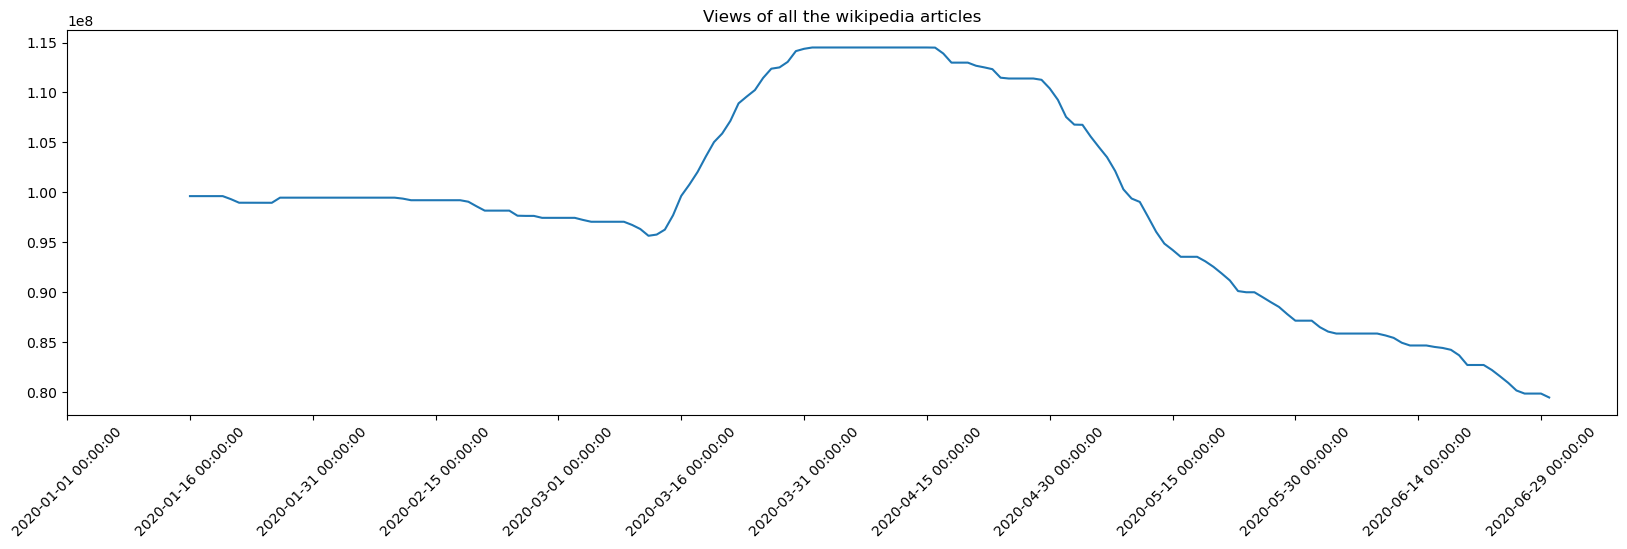

In [21]:
plotNormalization(views, maxLocal, [15])

In [22]:
viewsMax = maxLocal(views, 20)

In [23]:
def calculate_mean_derivative_front(data, window_size):
       
    if len(data) < window_size:
        raise ValueError("Window size should be less than or equal to the length of the data.")

    # Calculate the derivative of the data
    derivative = np.gradient(data)

    # Calculate the mean derivative over the sliding window
    mean_derivative = np.convolve(derivative, np.ones(window_size)/window_size, mode='same')

    return mean_derivative

def calculate_mean_derivative_back(data, window_size):
       
    derivative = np.gradient(data)

    # Calculate the mean derivative over the sliding window
    mean_derivative = np.convolve(derivative, np.ones(window_size)/window_size, mode='valid')

    # Pad the result with zeros to match the length of the input data
    pad_length = len(data) - len(mean_derivative) + 1
    mean_derivative = np.pad(mean_derivative, (pad_length, 0), mode='constant', constant_values=0)

    return mean_derivative

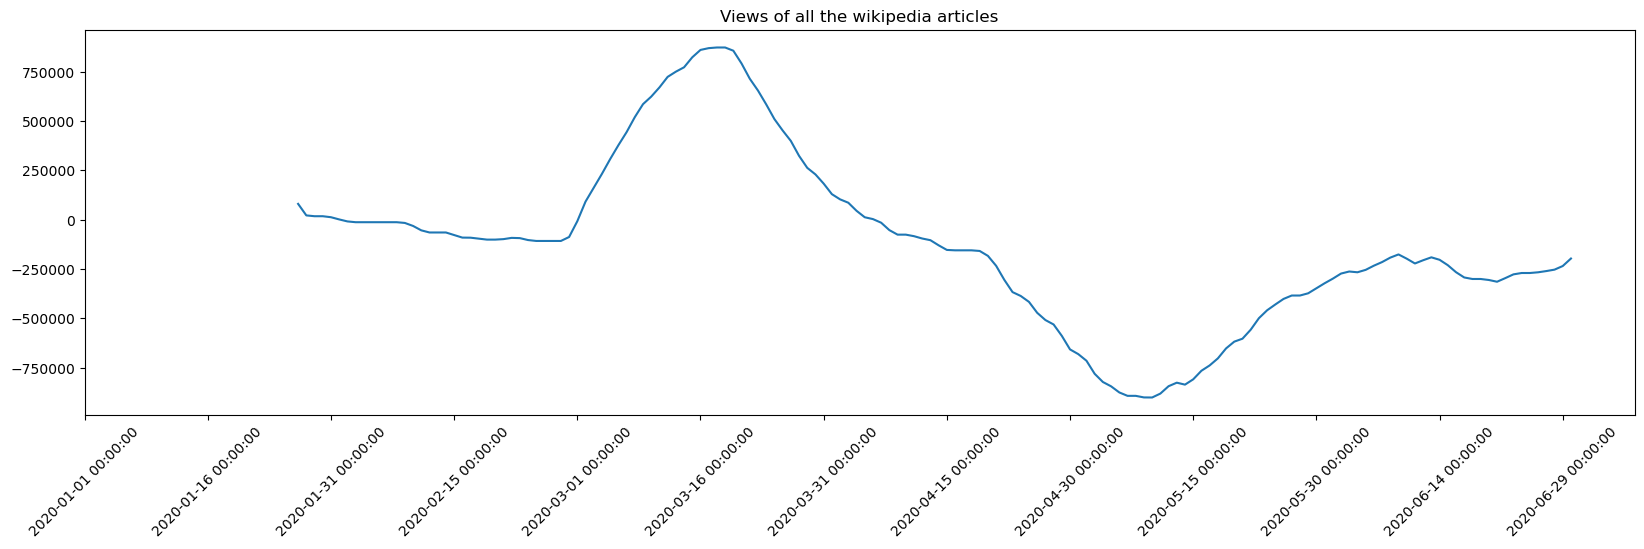

In [24]:
plotNormalization(viewsMax, calculate_mean_derivative_front, [20])

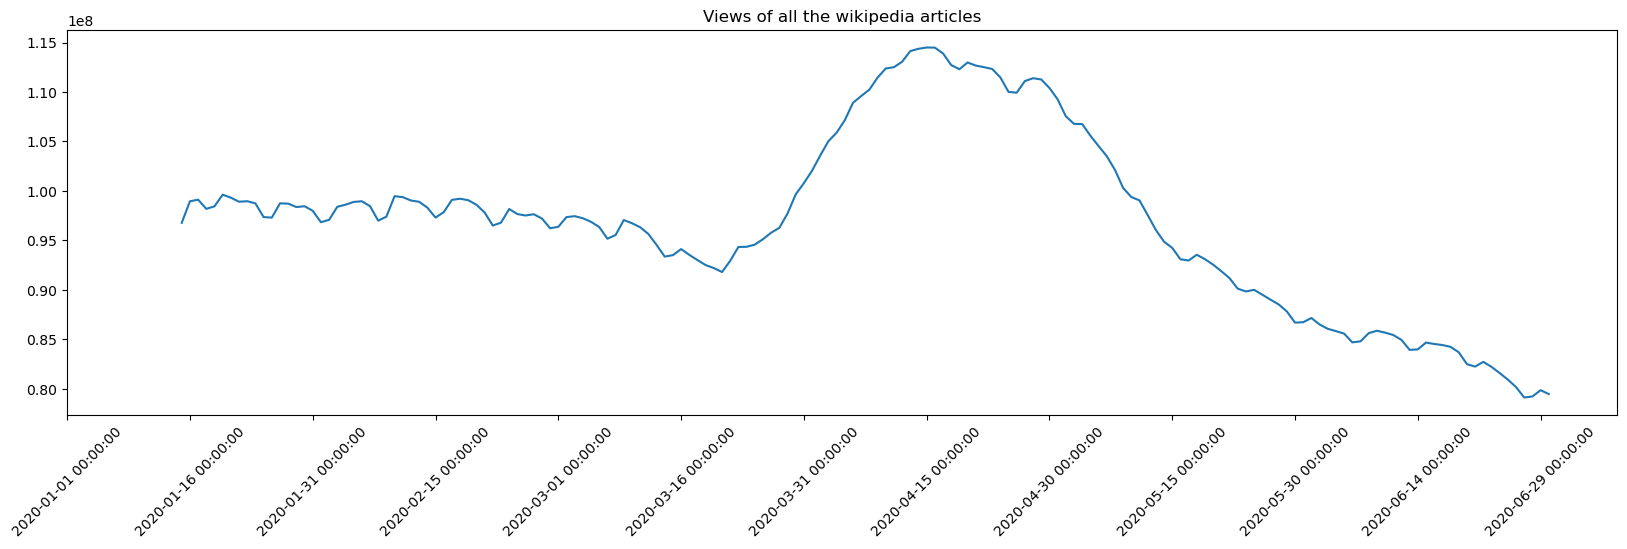

In [25]:
plotNormalization(views, nonefunction)

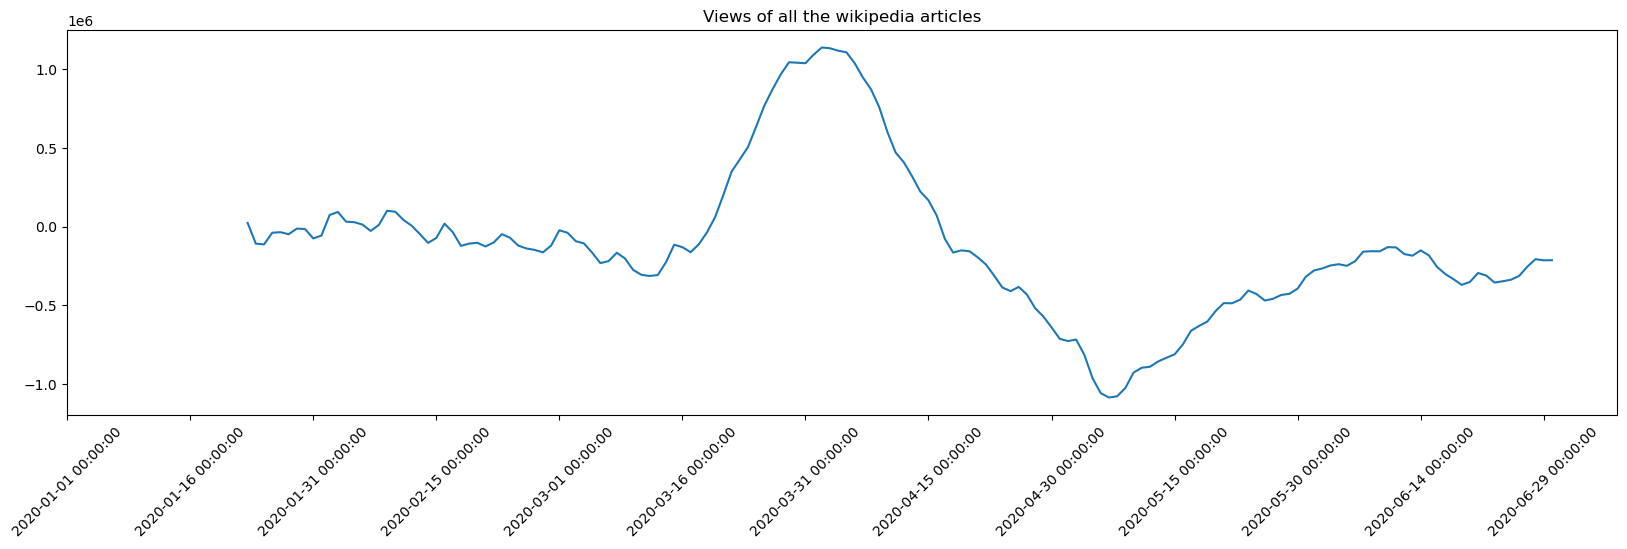

In [26]:
plotNormalization(views, calculate_mean_derivative_front, [15])

### derivative

In [27]:
def derivate(data, window_size):
    derivative = np.gradient(data)
    allDerivatives = []

    for i in range(window_size, len(derivative)):
        allDerivatives.append(derivative[i - window_size // 2:i + window_size // 2].mean())

    # If < 0, put 0
    allDerivatives = [0 if x < 0 else x for x in allDerivatives]

    # Add some zeros at the beginning and the end to have the same length
    allDerivatives = np.concatenate((np.zeros(window_size // 2), allDerivatives, np.zeros(window_size // 2)))
    
    #append the amount of 0 to have the same length
    allDerivatives = np.concatenate((np.zeros(len(data)-len(allDerivatives)), allDerivatives))
    

    #if Nan put 0
    allDerivatives = [0 if np.isnan(x) else x for x in allDerivatives]

    return allDerivatives



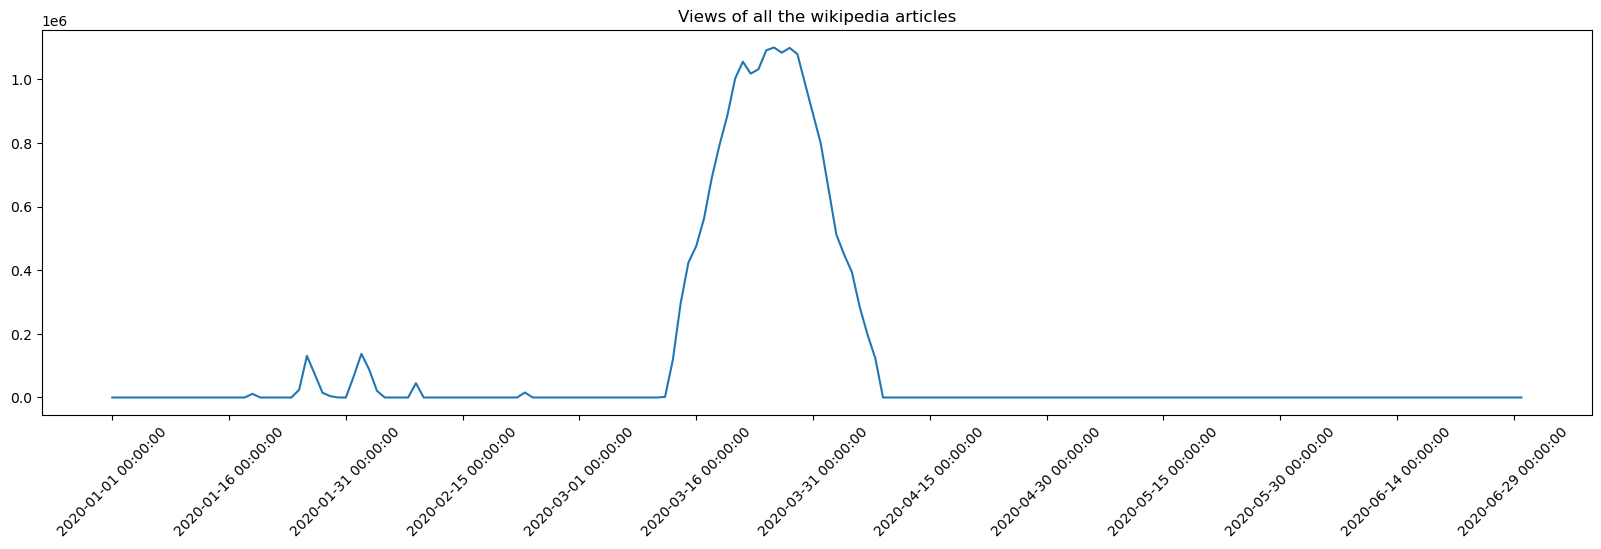

In [28]:
plotNormalization(views, derivate, [16])

In [29]:
derivative = derivate(views, 16)

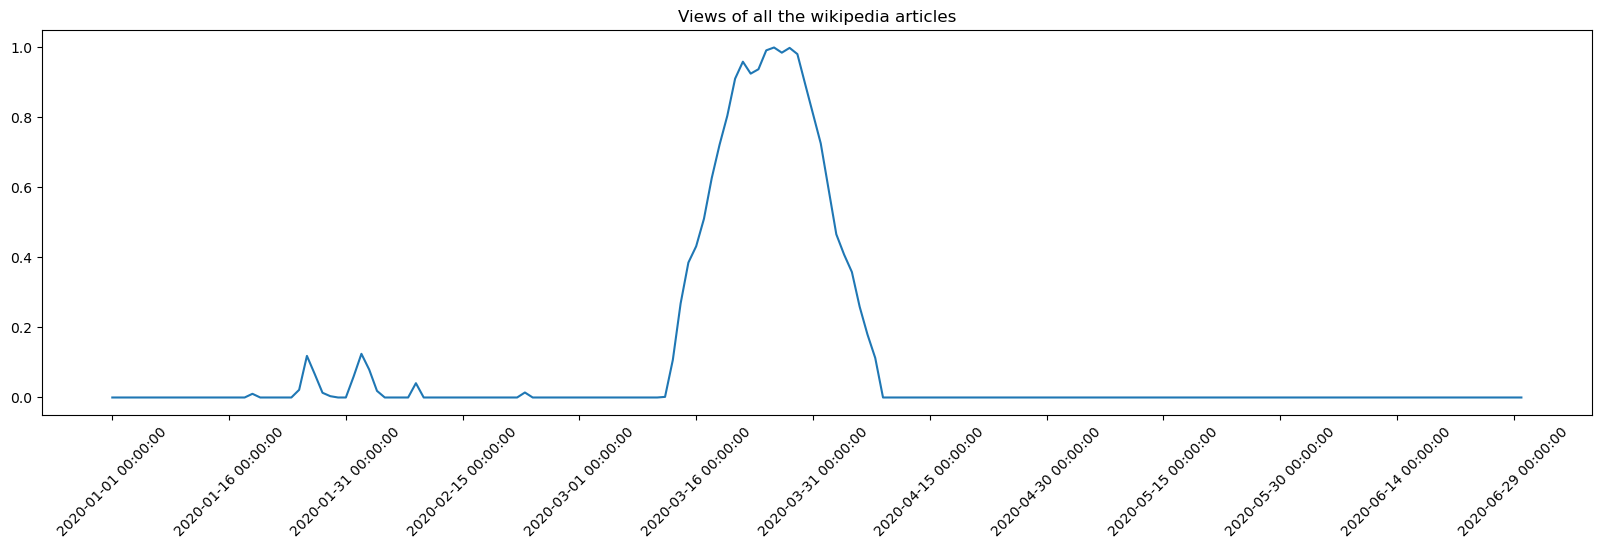

In [30]:
plotNormalization(derivative, minMax)

## Let's dog into it

In [184]:
df_fakecovidNews["Main Heading"].unique()

array(['Virus origin', 'Incidence and mortality', 'Disease spread',
       'Prevention', 'Treatment'], dtype=object)

In [185]:
topic = wikiTopic(df_fakecovidNews, "Treatment")

Error fetching data for . Status Code: 404


In [186]:
def finalNormalization(views, wikiViews, timestamp_wiki, timestamp_article, args = [10,16]):

    commonIndexes = []
    timestamp_wiki_string = [str(i) for i in timestamp_wiki]

    for i in range(len(timestamp_article)):
        if(str(timestamp_article[i]) in list(timestamp_wiki_string)):
            commonIndexes.append(i)


    #views = np.array(list(views))[commonIndexes]
    views = np.array(views)
    wikiViews = wikiViews[commonIndexes]


    viewsArticle = pd.Series(views).rolling(args[0]).mean()
    wikiViews = pd.Series(wikiViews).rolling(15).mean()
    derivative = derivate(viewsArticle, args[1])
    derivativeWiki = derivate(wikiViews, args[1])


    viewsMax = minMax(derivative)
    viewsMaxWiki = minMax(derivativeWiki)

    diff = viewsMax-viewsMaxWiki

    diff[diff < 0] = 0

    return diff, viewsMax, viewsMaxWiki, wikiViews, viewsArticle

In [187]:
norm = []
timestampTotal = []

#put timestamo as index of dataframe
df_norm = pd.DataFrame()

df_norm["views"] = 0


for i in range(0,len(topic.dfViewFinal)):

    curentArticle = topic.dfViewFinal[i]

    timestampsArticle = curentArticle['timestamp']
    viewsArticle = curentArticle['views']

    normalization, viewsMaxArticle, viewMaxWiki, wikiViews, viewsArticlesNorm = finalNormalization(viewsArticle, views_wiki, timestampsArticle, timestamp_wiki, args=[5, 10])

    #make a new column with the name of the article
    df_norm[curentArticle['article'].unique()[0]] = 0

    #put the normalization in the column at the corresponding timestamp
    for j in range(len(timestampsArticle)):
        df_norm.loc[timestampsArticle[j], curentArticle['article'].unique()[0]] = normalization[j]/len(topic.dfViewFinal)
        
    #df_norm.loc[timestampsArticle, "views"] = normalization




C:\Users\pablo\AppData\Local\Temp\ipykernel_6968\541656823.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.003879269561926383' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_norm.loc[timestampsArticle[j], curentArticle['article'].unique()[0]] = normalization[j]/len(topic.dfViewFinal)
C:\Users\pablo\AppData\Local\Temp\ipykernel_6968\541656823.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.007036280551132033' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_norm.loc[timestampsArticle[j], curentArticle['article'].unique()[0]] = normalization[j]/len(topic.dfViewFinal)
C:\Users\pablo\AppData\Local\Temp\ipykernel_6968\541656823.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

In [188]:
#sum all the columns into views
df_norm["views"] = df_norm.sum(axis=1)

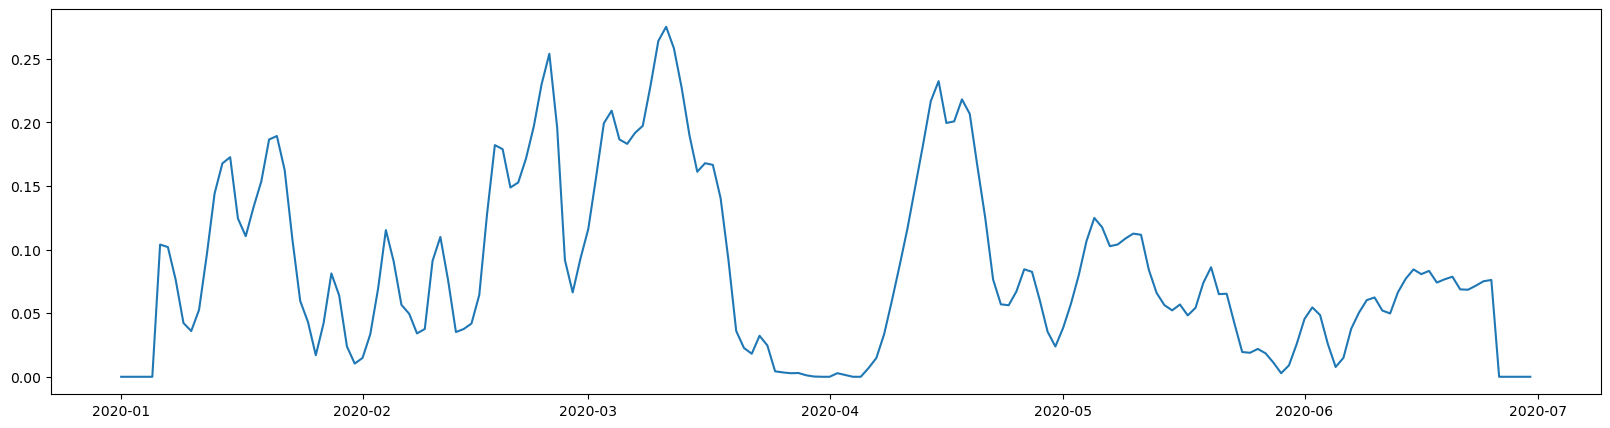

In [189]:
#plot the normalization of the views
plt.figure(figsize=(20,5))
plt.plot((df_norm.index), list(df_norm["views"]))

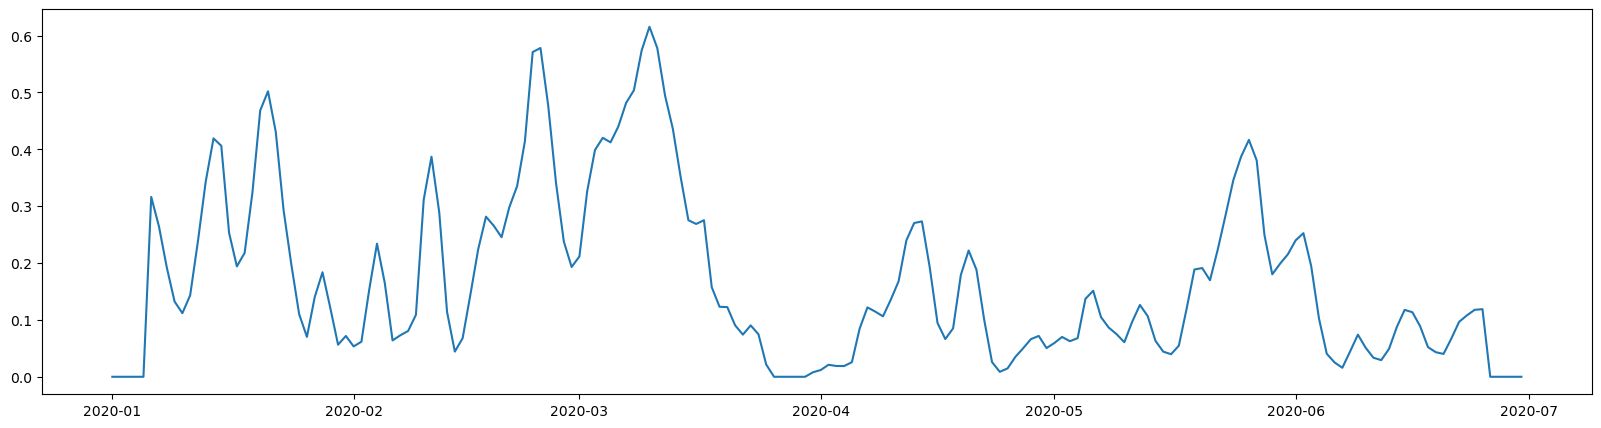

In [183]:
#plot the normalization of the views
plt.figure(figsize=(20,5))
plt.plot((df_norm.index), list(df_norm["views"]))